# Demo frequency analysis on new solver 1D.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from frequency import frequentiel_analysis
import importlib.util, sys

Loading the 1D (non heat source) refined solver. Located in `solver1D.py`

In [4]:
path = "solver1D.py"
spec = importlib.util.spec_from_file_location("solver1D", path)
solver = importlib.util.module_from_spec(spec)
sys.modules["solver1D"] = solver
spec.loader.exec_module(solver)

Create multi periodic signal for the river surface.

In [5]:
def make_multiperiodic_anomaly(t_s, components, noise_std=0.0, rng_seed=None):
    """
    Build theta_top(t) = sum_k A_k * cos(2π t / P_k + phi_k) + ε(t)
    where components = [{"amp": A_k, "period_s": P_k, "phase": phi_k}, ...].
    The result has zero mean if ε is zero-mean.
    """
    theta = np.zeros_like(t_s, dtype=float)
    for comp in components:
        A   = comp.get("amp", 0.0)
        P   = comp.get("period_s", 1.0)
        phi = comp.get("phase", 0.0)
        theta += A * np.cos(2*np.pi*t_s / P + phi)
    if noise_std > 0:
        rng = np.random.default_rng(rng_seed)
        theta += rng.normal(0.0, noise_std, size=theta.shape)
    # small numerical debias just in case
    theta -= theta.mean()
    return theta

Parameters for simulation.

In [6]:
dt = 900.0                       # 15 min
days = 30                        # simulate 30 days
t_s = np.arange(0, days*24*3600 + dt, dt)

components = [
    {"amp": 1.00, "period_s": 24*3600.0,  "phase": 0.2},   # diurnal (1 °C)
    {"amp": 0.30, "period_s": 12*3600.0,  "phase": -1.0},  # semi-diurnal (0.3 °C)
    {"amp": 0.50, "period_s": 7*24*3600., "phase": 0.7},   # weekly (0.5 °C)
    {"amp": 0.20, "period_s": 30*24*3600., "phase": -0.5},  # monthly (0.2 °C)
]

theta_top = make_multiperiodic_anomaly(t_s, components, noise_std=0.03, rng_seed=42)
T0 = 12.0
T_riv = T0 + theta_top

Displaying the river multiperiodic temperature signal

Text(0.5, 1.0, 'Multiperiodic Signal — 30 Days')

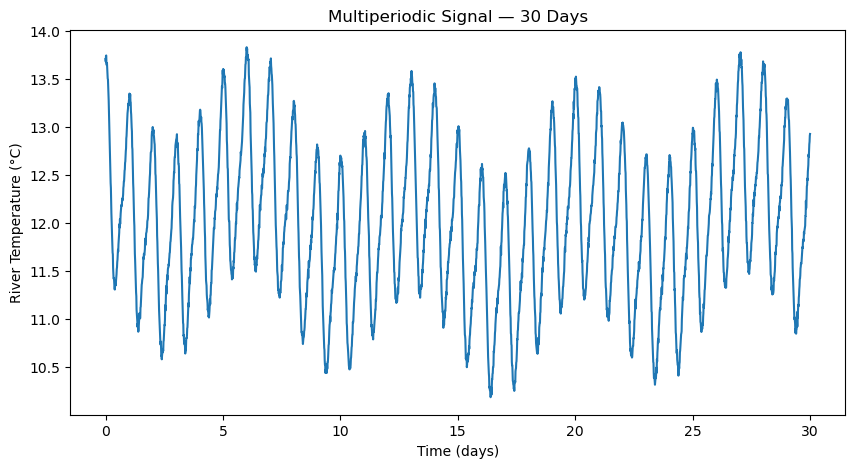

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(t_s/86400.0, T_riv)
plt.xlabel("Time (days)")
plt.ylabel("River Temperature (°C)")
plt.title("Multiperiodic Signal — 30 Days")

### Running the simulation and extracting temperature profiles at sensors.

In [10]:
geom  = solver.Geometry(L=1.0, z_max=0.6, Nz=241)
mat   = solver.Material(k_intrinsic=1e-10, n=0.1, lambda_m=1.0, rho_c_s=4e6)
fluid = solver.FluidProps()
#dH_t  = np.zeros_like(t_s)  # no advection for this demo
dH_t = np.full_like(t_s, 0.001)

z, theta, v = solver.simulate_split_anomaly(t_s, theta_top, dH_t, geom, mat, fluid)

# Extract and plot T(t) at 0.10, 0.20, 0.30 m over the last 3 days
z_targets = [0.10, 0.20, 0.30]
theta_probe = solver.interp_at(z, theta, z_targets)
T_probe = solver.to_temperature(theta_probe, T0=T0)

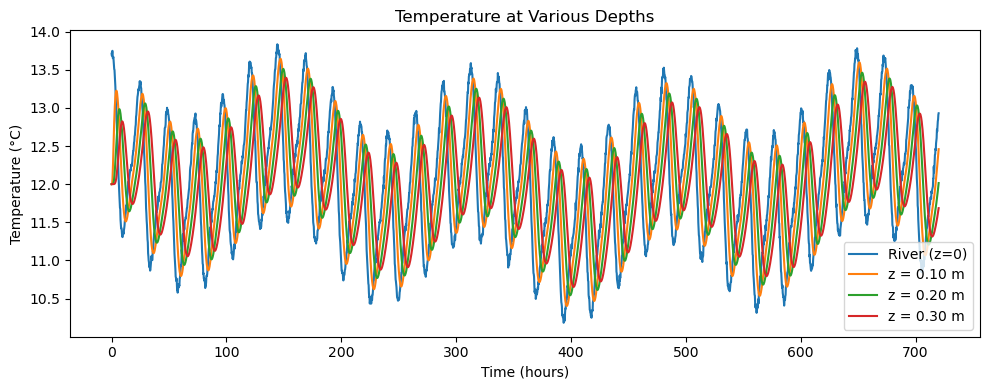

In [11]:
plt.figure(figsize=(10,4))
plt.plot((t_s)/3600.0, T_riv, label="River (z=0)")
for i, zt in enumerate(z_targets):
    plt.plot((t_s)/3600.0, T_probe[:, i], label=f"z = {zt:.2f} m")
plt.xlabel("Time (hours)")
plt.ylabel("Temperature (°C)")
plt.title("Temperature at Various Depths")
plt.legend()
plt.tight_layout()
plt.show()

### Frequency analysis using the created class `frequency`.

Frequentiel analysis module initialized.
This module will analyze a multi-periodic signal to estimate attenuation and phase decay coefficients.
Using phase decay and amplitude attenuation with depth, we'll retrieve kappa_e and v_t for each dominant period.


/Users/noedaniel/Desktop/Freq_Molonari/MOLONARI1D/fréquentiel/frequency.py:309: RuntimeWarning: divide by zero encountered in divide
  plt.plot(1.0 / (freqs * 86400.0), amp, label=f'Sensor at depth {depths[i]} m')


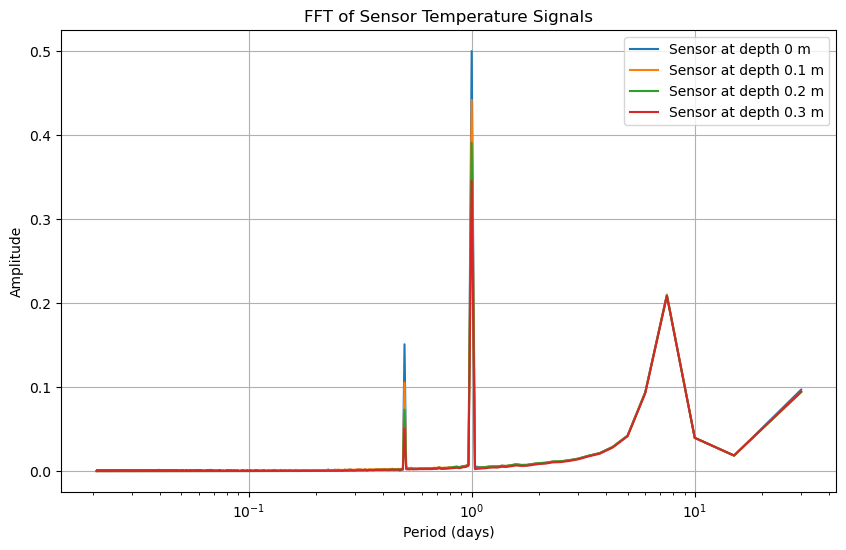

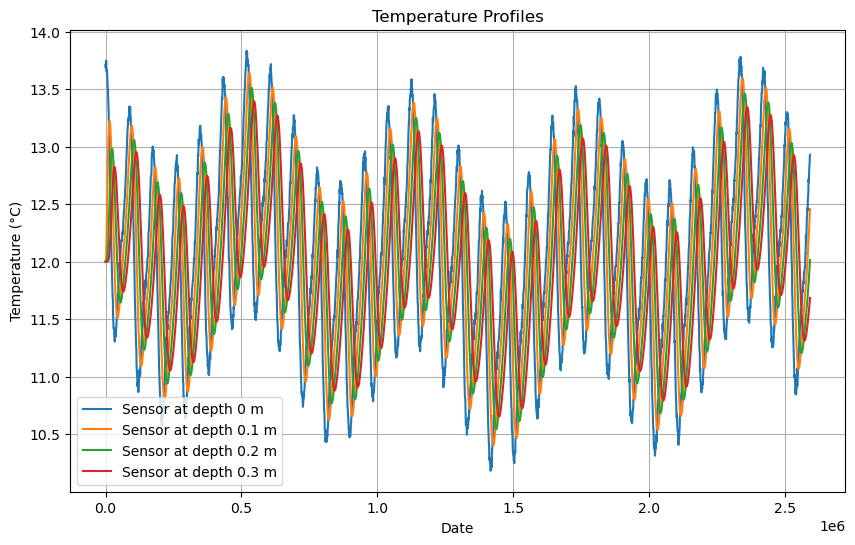

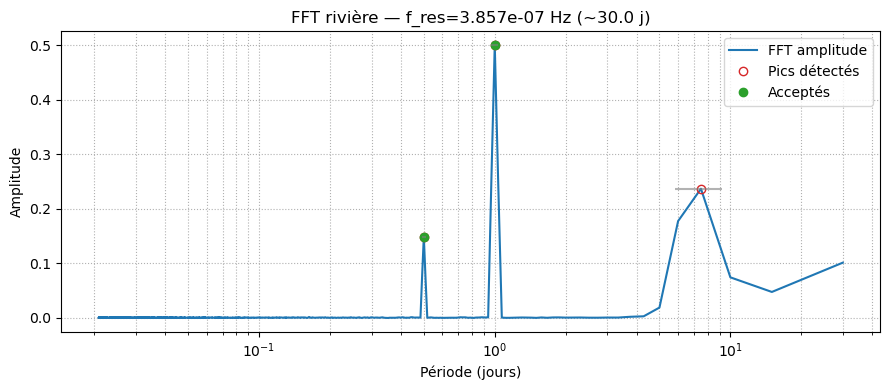

Detected depths: [0.  0.1 0.2 0.3]
Amplitudes at dominant periods for each signal computed.
Period 1.00 days: Amplitudes = [0.49970963 0.44177282 0.39055679 0.34577404]
Period 0.50 days: Amplitudes = [0.15090695 0.10523287 0.07310506 0.05015352]


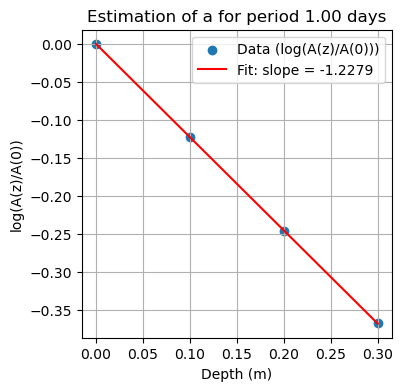

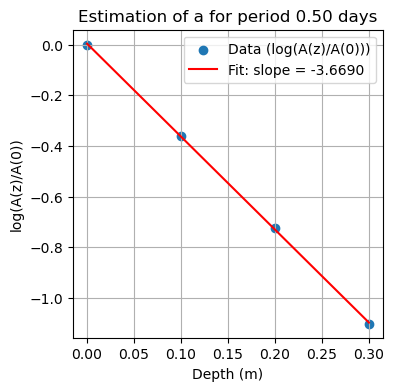

Attenuation coefficients a estimated for each dominant period.
Period 1.00 days: a = 1.2279 1/m
Period 1.00 days: R^2 = 1.0000
Period 0.50 days: a = 3.6690 1/m
Period 0.50 days: R^2 = 0.9999


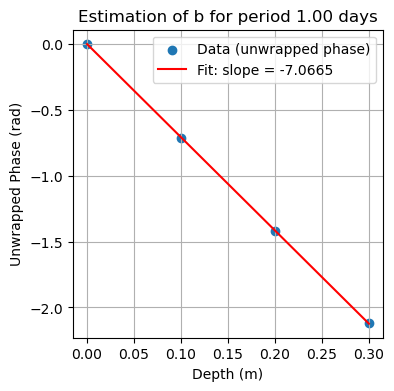

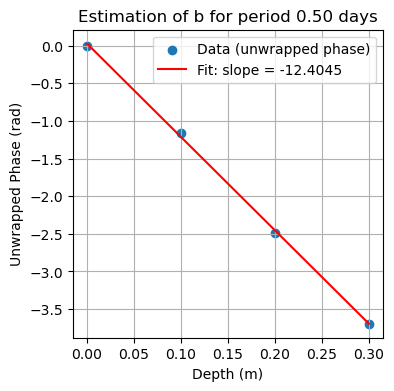

Phase decay coefficients b estimated for each dominant period.
Period 1.00 days: b = 7.0665 rad/m
Period 1.00 days: R^2 = 1.0000
Period 0.50 days: b = 12.4045 rad/m
Period 0.50 days: R^2 = 0.9994
Verification des constantes
[39.43818022 38.26909453]
Inversion complete.
Period 1.00 days: kappa_e = 2.456e-07 m^2/s, v_t = 9.684e-06 m/s
Period 0.50 days: kappa_e = 2.570e-07 m^2/s, v_t = 9.835e-06 m/s


In [12]:
fa = frequentiel_analysis()
dates = t_s
river = T_riv
temps_all = np.vstack([T_riv, T_probe.T, T_riv])
# temps_all shape: (n_sensors + 2, n_time) -> [0]=river, [1..n]=sensors, [-1]=aq
sensors = temps_all[1:-1]
signals = [river] + [sensors[i, :] for i in range(sensors.shape[0])]

# Take the 3 first values and add 0 
depth_sensors = [0, 0.10, 0.20, 0.30]

# Plotting check figures
fa.fft_sensors(dates, signals, depth_sensors)
fa.plot_temperatures(dates, signals, depth_sensors)

# Finding dominant periods
dominant_periods_days, dominant_freqs, dominant_amps, meta = fa.find_dominant_periods(signals, river, draw=True)

# Now filtering to only keep relevant periods (the ones we put in) using the meta info
# The mask is in meta['accepted_mask']

dominant_periods_days = dominant_periods_days[meta['accepted_mask']]
dominant_freqs = dominant_freqs[meta['accepted_mask']]
dominant_amps = dominant_amps[meta['accepted_mask']]

# Estimate a and b for these dominant periods
depths = np.array(depth_sensors)
a_est, a_R2 = fa.estimate_a(dates, signals, depths, dominant_periods_days, verbose=True, draw=True)
b_est, b_R2 = fa.estimate_b(dates, signals, depths, dominant_periods_days, verbose=True, draw=True)

# Checking constants
fa.check_constantes(a_est, b_est)

kappa_e, v_t = fa.perform_inversion(a_est, b_est, dominant_periods_days, verbose=True)

### Comparing to real values.

In [16]:
kappa_real = mat.kappa_e(fluid)
K_real = mat.hydraulic_conductivity(fluid)
n_real = mat.n
v_real = +(K_real / n_real) * (dH_t.mean() / geom.L)  # sign convention: positive downward if dH>0

print(f"Real kappa_e: {kappa_real:.3e} m²/s")
print(f"Real v_t: {v_real:.3e} m/s")


Real kappa_e: 2.489e-07 m²/s
Real v_t: 9.790e-06 m/s
